# Stock Return Analysis & Classification

## Introduction & Motivation

Financial markets are inherently noisy and volatile, with stock prices influenced by a wide range of external factors and human behavior. This uncertainty makes short-term price movements difficult to model and challenges the assumption that clear, stable patterns exist in historical price data.

This project stems from a growing interest in financial markets alongside an introductory background in machine learning. Rather than assuming predictability, the goal is to explore how standard machine learning techniques behave when applied to financial time-series data. In particular, the project investigates whether commonly used statistical and technical features such as returns, moving averages, and rolling volatility capture any consistent structure in daily stock price movement.

By analyzing historical stock data and evaluating simple classification models, this project aims to better understand both the potential and the limitations of applying machine learning to uncertain, real-world financial data.

---

### Key Characteristics of This Project
- Exploratory rather than predictive in nature  
- Focused on understanding behavior and limitations, not forecasting accuracy  
- Uses historical daily stock data as a case study for noisy time-series modeling  

---

### What This Project Does *Not* Claim
- It does **not** attempt to beat the market or generate a trading strategy  
- It does **not** assume short-term stock movements are reliably predictable  


---

## Libraries and Dependencies

This project relies on a small set of Python libraries to support data acquisition, numerical analysis, visualization, and preprocessing. Each library is used with a specific role in the analysis pipeline.

### Data Acquisition
- **yfinance** is used to retrieve historical daily stock price data from Yahoo Finance. This provides reproducible, publicly available market data and defines the temporal resolution (daily) of the analysis.


In [1]:
import yfinance as yf

### Data Manipulation and Numerical Analysis
- **pandas** and **numpy** are used for structured time-series manipulation and numerical computation. These libraries support feature engineering operations such as return calculation, rolling statistics, and time-based aggregation.

### Exploratory Data Analysis and Visualization
- **matplotlib** and **seaborn** are used to visualize price trends, return distributions, and volatility behavior. Visualizations are used primarily for exploratory analysis and interpretation rather than presentation.

### Outlier Handling
- **winsorize** from `scipy.stats.mstats` is used to limit the influence of extreme return values. Financial return data is often heavy-tailed, and winsorization provides a simple way to reduce the impact of rare but extreme observations without removing data points entirely.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

### Warning Management
- Python warnings are suppressed to improve notebook readability. This helps keep the focus on analysis results rather than non-critical library warnings, while assuming careful handling of data preprocessing steps.

In [45]:
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

The first step in the analysis is to obtain historical stock price data that will serve as the foundation for all subsequent feature engineering and modeling.

Historical daily price data is retrieved using the `yfinance` library, which requires a stock’s ticker symbol along with a specified start and end date in `YYYY-MM-DD` format.

To improve reproducibility and separate data collection from analysis, the retrieved data is saved locally as a `.csv` file in a dedicated data directory.


In [46]:
df = yf.download('NKE', start='2020-01-01', end='2024-01-01', auto_adjust=True).to_csv('Datasets/nike_stock.csv')

[*********************100%***********************]  1 of 1 completed


Setting `auto_adjust=True` makes our Close columun use Adjusted Close values, which are preferred while analyzing stocks

## Data Cleaning and Formatting

After loading the raw stock price data, the dataset is converted into a Pandas DataFrame to enable structured manipulation and analysis.

In [47]:
nike = pd.read_csv('../Datasets/nike_stock.csv')
nike

,Price,Close,High,Low,Open,Volume
0,Ticker,NKE,NKE,NKE,NKE,NKE
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,95.36821746826172,95.3775509900979,94.26709683150074,94.58437249941043,5644100
3,2020-01-03,95.10693359375,95.18158752791594,93.6045569857679,93.86583863595764,4541800
4,2020-01-06,95.0229263305664,95.03225273015106,94.12710073259969,94.20174752622184,4612400
...,...,...,...,...,...,...
1003,2023-12-22,104.98536682128906,107.66733492795588,104.41204414073968,105.19914790848757,46666200
1004,2023-12-26,104.96592712402344,105.61698972341972,104.44120116881932,105.2380168592794,12846700
1005,2023-12-27,104.1010971069336,105.51981745011808,103.8290147690198,105.27688573216825,10157900
1006,2023-12-28,105.7433090209961,106.30691233863952,103.79013609671432,104.17882829556108,9352900


Due to the CSV export format, the first row of the dataset contains the stock ticker label repeated across columns rather than actual numerical values. This row is removed to ensure that all remaining rows represent valid daily observations.

In [48]:
nike = nike.drop([0,1],axis=0)
nike

,Price,Close,High,Low,Open,Volume
2,2020-01-02,95.36821746826172,95.3775509900979,94.26709683150074,94.58437249941043,5644100
3,2020-01-03,95.10693359375,95.18158752791594,93.6045569857679,93.86583863595764,4541800
4,2020-01-06,95.0229263305664,95.03225273015106,94.12710073259969,94.20174752622184,4612400
5,2020-01-07,94.97627258300781,95.87209824443295,94.07111340194787,95.00426602252274,6719900
6,2020-01-08,94.76165771484375,95.31221437997459,94.10844656574092,94.53769594517937,4942200
...,...,...,...,...,...,...
1003,2023-12-22,104.98536682128906,107.66733492795588,104.41204414073968,105.19914790848757,46666200
1004,2023-12-26,104.96592712402344,105.61698972341972,104.44120116881932,105.2380168592794,12846700
1005,2023-12-27,104.1010971069336,105.51981745011808,103.8290147690198,105.27688573216825,10157900
1006,2023-12-28,105.7433090209961,106.30691233863952,103.79013609671432,104.17882829556108,9352900


Column names are then standardized, and the date column is explicitly reformatted to ensure consistent naming and interpretation. The date column is converted to a datetime format to support time-series operations such as sorting, indexing, and rolling-window calculations.

In [49]:
nike['Date'] = nike['Price']
nike = nike.drop('Price',axis=1)

nike

,Close,High,Low,Open,Volume,Date
2,95.36821746826172,95.3775509900979,94.26709683150074,94.58437249941043,5644100,2020-01-02
3,95.10693359375,95.18158752791594,93.6045569857679,93.86583863595764,4541800,2020-01-03
4,95.0229263305664,95.03225273015106,94.12710073259969,94.20174752622184,4612400,2020-01-06
5,94.97627258300781,95.87209824443295,94.07111340194787,95.00426602252274,6719900,2020-01-07
6,94.76165771484375,95.31221437997459,94.10844656574092,94.53769594517937,4942200,2020-01-08
...,...,...,...,...,...,...
1003,104.98536682128906,107.66733492795588,104.41204414073968,105.19914790848757,46666200,2023-12-22
1004,104.96592712402344,105.61698972341972,104.44120116881932,105.2380168592794,12846700,2023-12-26
1005,104.1010971069336,105.51981745011808,103.8290147690198,105.27688573216825,10157900,2023-12-27
1006,105.7433090209961,106.30691233863952,103.79013609671432,104.17882829556108,9352900,2023-12-28


Finally, price and volume columns are converted to numeric types. Explicit type conversion ensures that downstream feature engineering and statistical operations behave as expected and prevents silent errors caused by incorrect data types.

In [50]:
for i in nike.columns:
    if i != 'Date':
        nike[i] = pd.to_numeric(nike[i])
    else:
        nike[i] = pd.to_datetime(nike[i])

nike

,Close,High,Low,Open,Volume,Date
2,95.368217,95.377551,94.267097,94.584372,5644100,2020-01-02
3,95.106934,95.181588,93.604557,93.865839,4541800,2020-01-03
4,95.022926,95.032253,94.127101,94.201748,4612400,2020-01-06
5,94.976273,95.872098,94.071113,95.004266,6719900,2020-01-07
6,94.761658,95.312214,94.108447,94.537696,4942200,2020-01-08
...,...,...,...,...,...,...
1003,104.985367,107.667335,104.412044,105.199148,46666200,2023-12-22
1004,104.965927,105.616990,104.441201,105.238017,12846700,2023-12-26
1005,104.101097,105.519817,103.829015,105.276886,10157900,2023-12-27
1006,105.743309,106.306912,103.790136,104.178828,9352900,2023-12-28


Running `pd.describe()` helps us see valuable information like the amount of data, avg no of trades over the span of the range provided and the minimum and maximum value of the stock's OHLC(Open, High, Low, Close)

In [51]:
nike.describe().round(2)

,Close,High,Low,Open,Volume,Date
count,1006.00,1006.00,1006.00,1006.00,1006.00,1006
mean,115.49,116.78,114.19,115.50,7271308.75,2021-12-30 11:57:08.230616320
min,58.76,62.58,56.14,60.63,1821900.00,2020-01-02 00:00:00
25%,99.54,100.70,98.62,99.55,5065750.00,2020-12-30 06:00:00
50%,113.73,115.46,112.78,114.07,6275250.00,2021-12-29 12:00:00
75%,128.18,129.79,126.68,128.24,8102450.00,2022-12-28 18:00:00
max,168.18,169.68,166.27,167.08,48176100.00,2023-12-29 00:00:00
std,21.94,22.01,21.94,22.02,4231354.48,NaN


## Stock Analysis (EDA)

Closing Price Over Time

The closing price is plotted to establish a high-level view of NKE’s price behavior over the selected period and to verify temporal consistency in the dataset. This provides context for later transformations, as raw prices are non-stationary and not directly suitable for modeling.

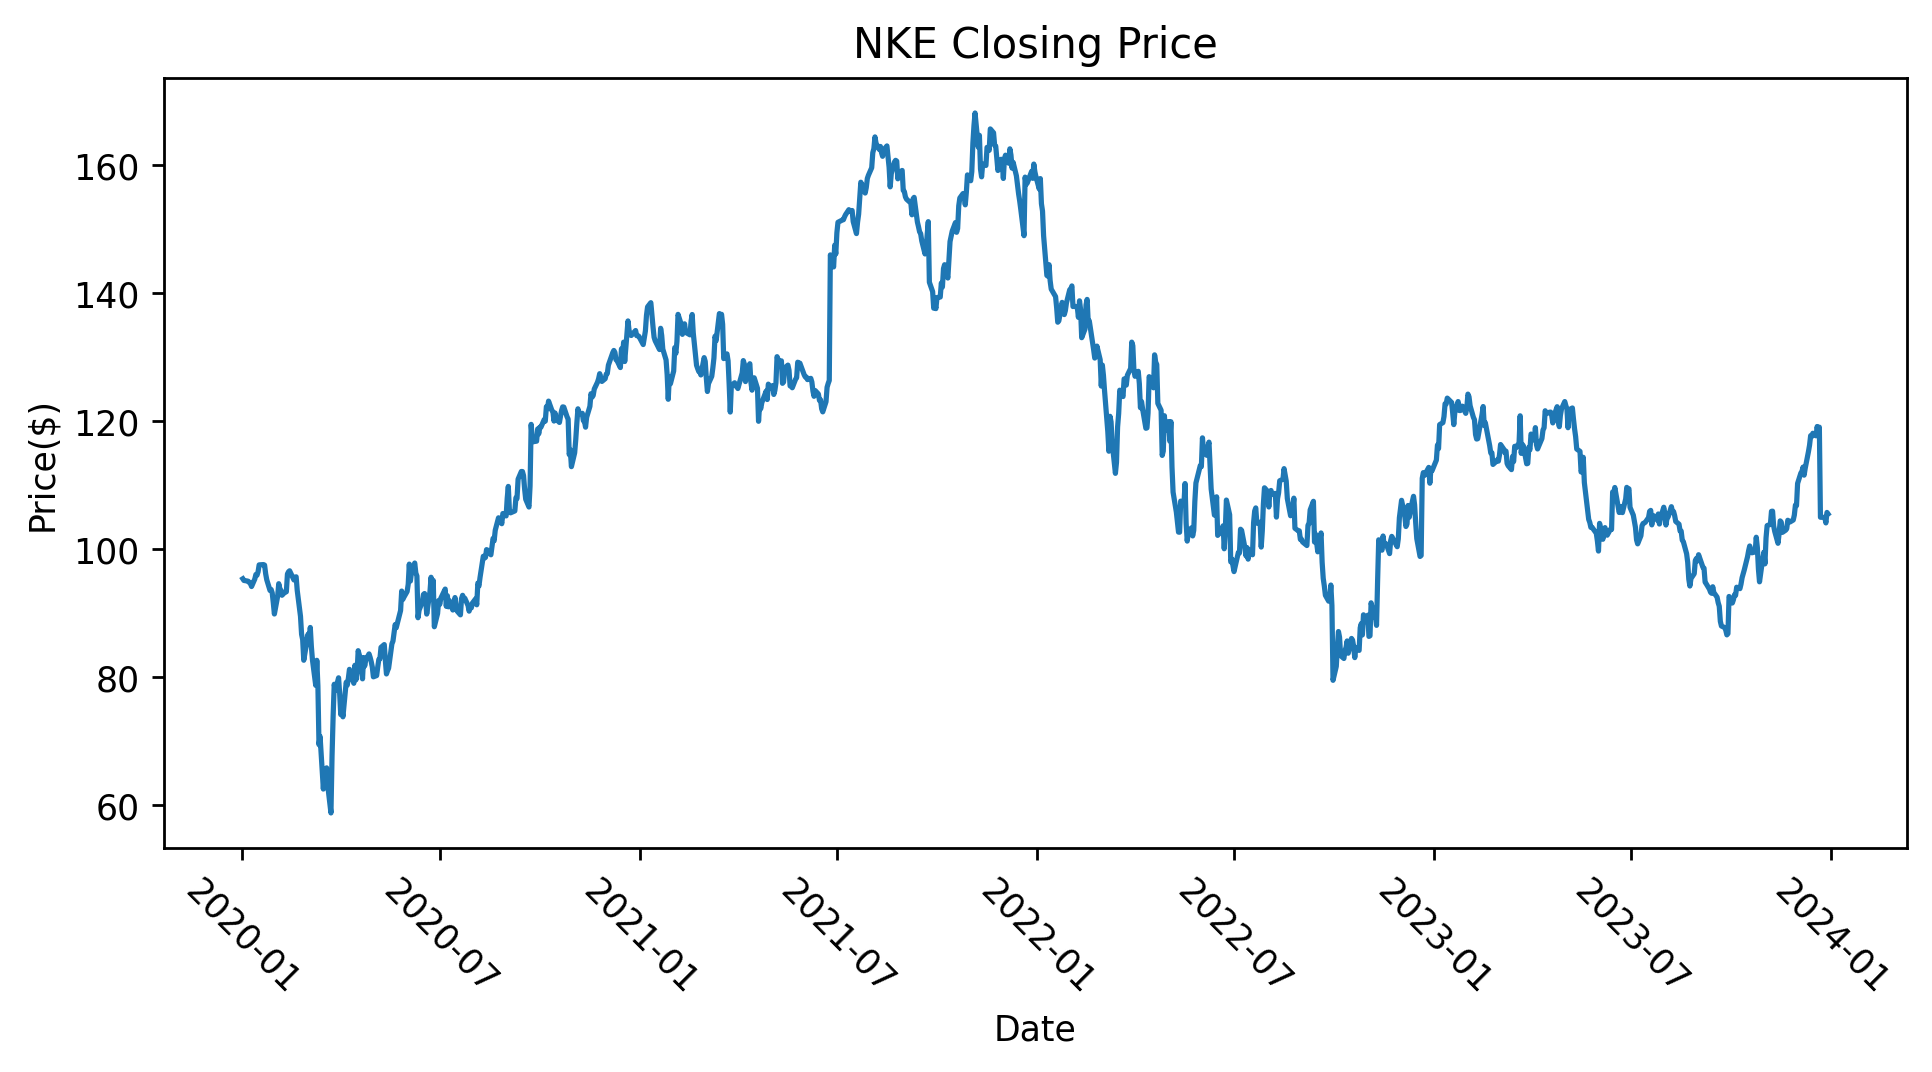

In [52]:
plt.figure(figsize=(9,4),dpi=250)
sns.lineplot(data=nike, x='Date', y='Close')
plt.title('NKE Closing Price')
plt.xticks(rotation=-45)
plt.ylabel('Price($)')
plt.show()

Returns are computed to shift the analysis from raw prices to relative price changes, which are more appropriate for statistical analysis and machine learning. This transformation emphasizes short-term variability rather than long-term trends.

Here we compute two ways returns can be assesed:
- The percent change within the same trading day, from market open to market close.
- The percent change from yesterday’s close to today’s close.

In [54]:
nike['Open-to-Close Return(%)'] = ((nike['Close'] - nike['Open'])/(nike['Open']))*100
nike['Log Return'] = np.log(nike['Close'] / nike['Close'].shift(1))
nike.head(10)

,Close,High,Low,Open,Volume,Date,Open-to-Close Return(%),Log Return
2,95.368217,95.377551,94.267097,94.584372,5644100,2020-01-02,0.828726,NaN
3,95.106934,95.181588,93.604557,93.865839,4541800,2020-01-03,1.322201,-0.002743
4,95.022926,95.032253,94.127101,94.201748,4612400,2020-01-06,0.871724,-0.000884
5,94.976273,95.872098,94.071113,95.004266,6719900,2020-01-07,-0.029465,-0.000491
6,94.761658,95.312214,94.108447,94.537696,4942200,2020-01-08,0.236902,-0.002262
7,94.696342,95.564175,94.612355,95.125592,5007500,2020-01-09,-0.451245,-0.000689
8,94.155098,95.116244,94.024457,95.078917,5135300,2020-01-10,-0.971634,-0.005732
9,95.330872,95.498832,94.080443,94.248411,6722400,2020-01-13,1.148518,0.012410
10,96.040070,96.945229,95.508173,95.601487,5088500,2020-01-14,0.458762,0.007412
11,95.918777,96.767943,95.629502,96.348027,4209200,2020-01-15,-0.445520,-0.001264


Day-to-Day Return Over Time

The day-to-day return plot highlights the high volatility and frequent sign changes in daily price movement. The absence of visually stable patterns suggests a low signal-to-noise ratio at daily resolution. We can see there are a few outliers and most retuns are compressed around -5 to 5 percent range, highlight minimal change day-to-day.

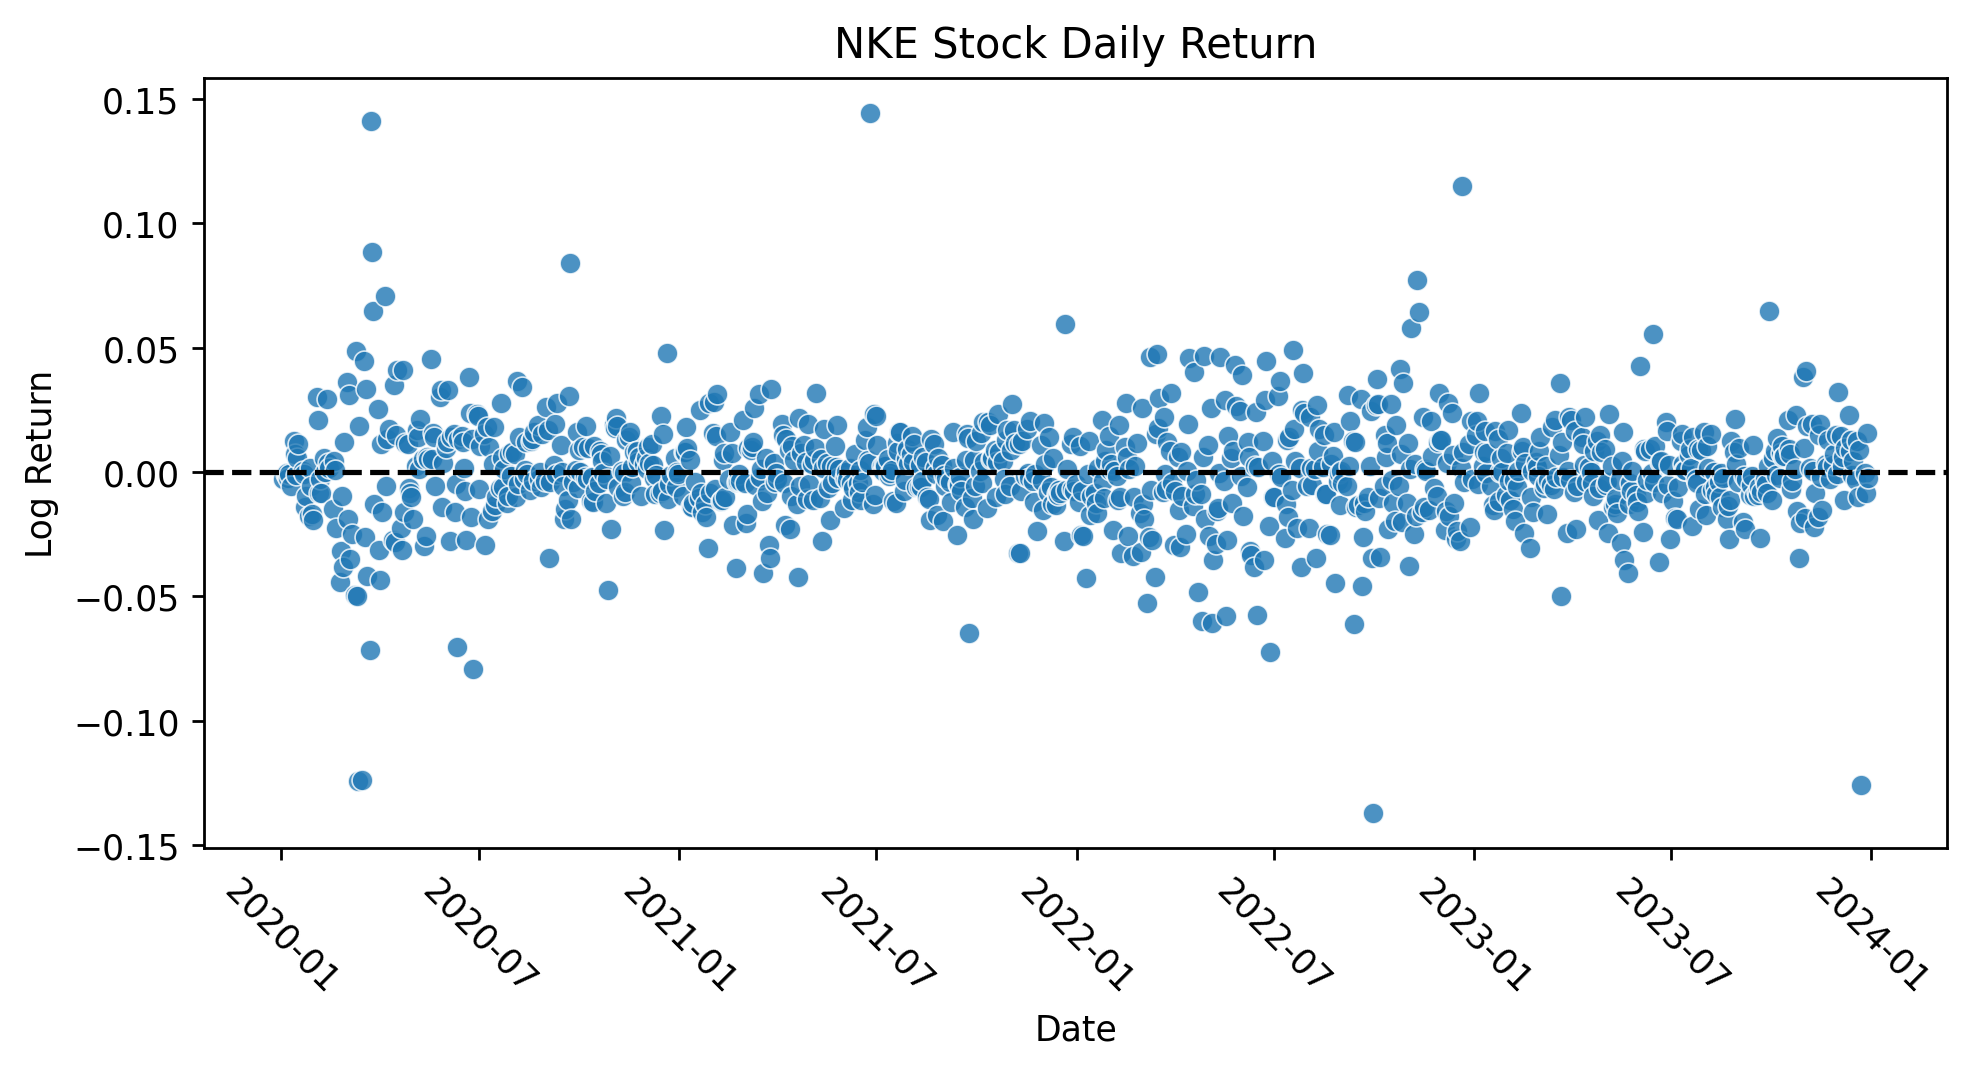

In [39]:
plt.figure(figsize=(9,4),dpi=250)
plt.title('NKE Stock Daily Return')
sns.scatterplot(data=nike, x='Date',y='Log Return',alpha=0.8)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=-45);

Distribution of Day-to-Day Returns

The return distribution is centered near zero with occasional extreme values, indicating heavy-tailed behavior common in financial data. This motivates the use of robust preprocessing techniques and cautious interpretation of model results.

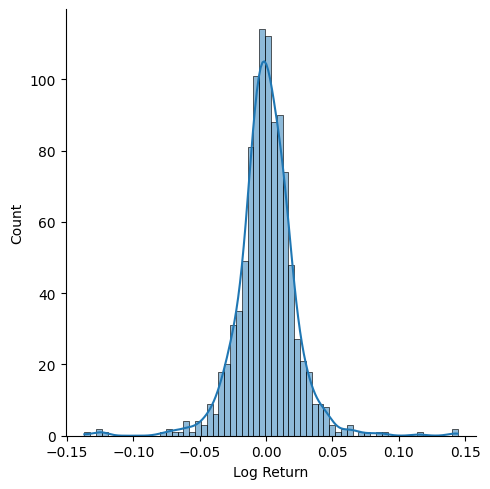

In [40]:
sns.displot(nike, x='Log Return',kde=True);

A 20-day simple moving average is introduced to smooth short-term fluctuations and highlight broader price trends. As a lagging indicator, SMA is primarily descriptive and may not capture rapid market changes.

In [16]:
nike['SMA20'] = nike['Close'].rolling(window=20).mean()
nike

,Close,High,Low,Open,Volume,Date,Open-to-Close Return(%),Log Return,NextDayReturn,SMA20
2,95.368217,95.377551,94.267097,94.584372,5644100,2020-01-02,0.828726,NaN,0,NaN
3,95.106934,95.181588,93.604557,93.865839,4541800,2020-01-03,1.322201,-0.002743,0,NaN
4,95.022926,95.032253,94.127101,94.201748,4612400,2020-01-06,0.871724,-0.000884,0,NaN
5,94.976273,95.872098,94.071113,95.004266,6719900,2020-01-07,-0.029465,-0.000491,0,NaN
6,94.761658,95.312214,94.108447,94.537696,4942200,2020-01-08,0.236902,-0.002262,0,NaN
...,...,...,...,...,...,...,...,...,...,...
1003,104.985367,107.667335,104.412044,105.199148,46666200,2023-12-22,-0.203216,-0.125854,0,112.940046
1004,104.965927,105.616990,104.441201,105.238017,12846700,2023-12-26,-0.258547,-0.000185,0,112.960561
1005,104.101097,105.519817,103.829015,105.276886,10157900,2023-12-27,-1.116854,-0.008273,1,112.899581
1006,105.743309,106.306912,103.790136,104.178828,9352900,2023-12-28,1.501726,0.015652,0,112.842265


The SMA20 graph imposed over the stock's closing price shows how it can be used to gauge short term trends and entry/exit points. However it comes with the drawback of a lagged price structure. 

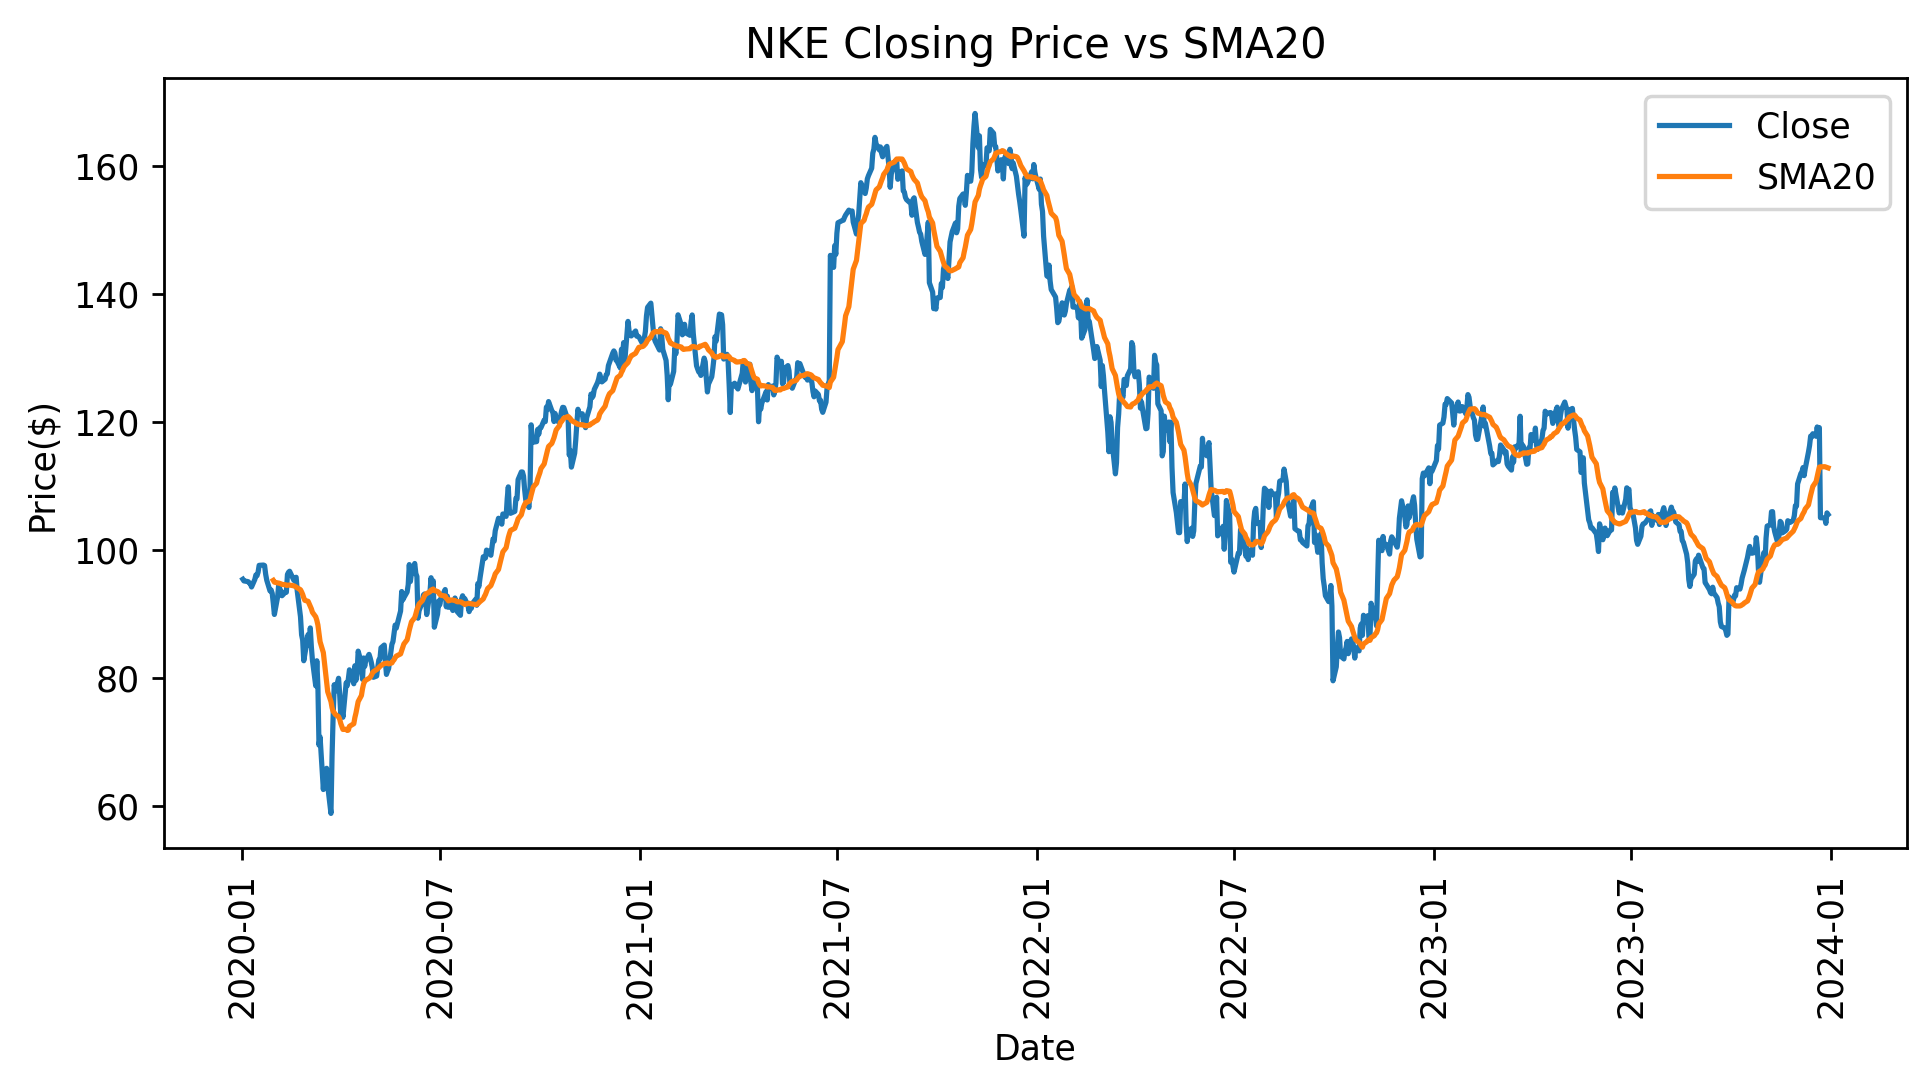

In [17]:
plt.figure(figsize=(9,4),dpi=250)
for col in ['Close', 'SMA20']:
    sns.lineplot(data=nike, x='Date', y=col, label=col)
plt.title('NKE Closing Price vs SMA20')
plt.xticks(rotation=90)
plt.ylabel('Price($)')
plt.legend()
plt.show()

## Volatility

Volatility is computed as the rolling standard deviation of daily log returns over a 20-day window. This provides a localized measure of market uncertainty and captures how return variability evolves over time rather than assuming constant risk.

In [18]:
nike['volatility'] = nike['Log Return'].rolling(window=20).std()
nike['volatility']

2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
          ...   
1003    0.031413
1004    0.031407
1005    0.031414
1006    0.031437
1007    0.031440
Name: volatility, Length: 1006, dtype: float64

Plotting rolling volatility over time reveals periods of elevated and suppressed uncertainty. Volatility clustering is evident, indicating that high-volatility periods tend to persist rather than occur randomly.

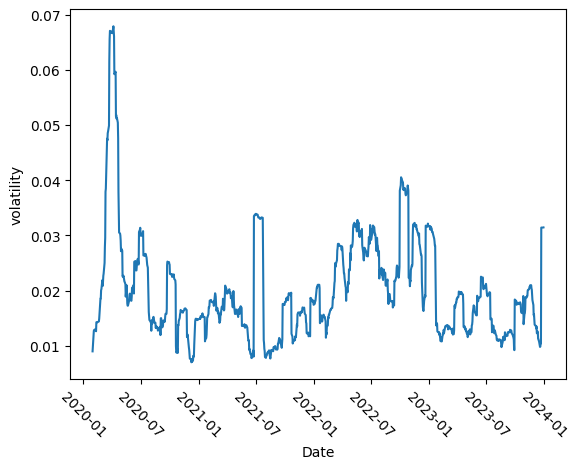

In [19]:
sns.lineplot(data=nike,x='Date',y='volatility')
plt.xticks(rotation=-45);

The distribution of rolling volatility highlights the range and skewness of market uncertainty. Most observations fall within a relatively narrow band, with occasional spikes corresponding to turbulent market periods.

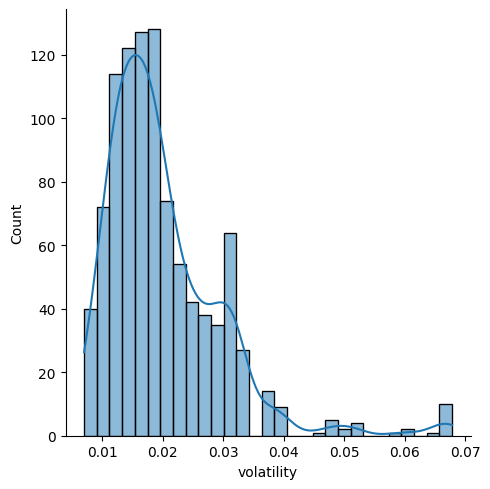

In [21]:
sns.displot(data=nike,x='volatility', kde='true');

We can see that the distribution is right-skewed, with most observations concentrated at low-to-moderate volatility levels. This shows that the market risk is asymmetric: calm periods are common, extreme uncertainty is infrequent but impactful.

## DateTime Analysis

Month, year, and day-of-week features are useful because stock market behavior can vary across time due to seasonality and trading behavior. These features help capture potential temporal patterns in returns or volatility and allow analysis to test whether market behavior changes across periods. While such effects are often weak and unstable, including time-based features provides context and helps assess whether stock movements are time-dependent or largely random.

In [56]:
nike['Month'] = nike['Date'].dt.month
nike['Year'] = nike['Date'].dt.year
nike['DayofWeek'] = nike['Date'].dt.day_of_week
nike

,Close,High,Low,Open,Volume,Date,Open-to-Close Return(%),Log Return,Month,Year,DayofWeek
2,95.368217,95.377551,94.267097,94.584372,5644100,2020-01-02,0.828726,NaN,1,2020,3
3,95.106934,95.181588,93.604557,93.865839,4541800,2020-01-03,1.322201,-0.002743,1,2020,4
4,95.022926,95.032253,94.127101,94.201748,4612400,2020-01-06,0.871724,-0.000884,1,2020,0
5,94.976273,95.872098,94.071113,95.004266,6719900,2020-01-07,-0.029465,-0.000491,1,2020,1
6,94.761658,95.312214,94.108447,94.537696,4942200,2020-01-08,0.236902,-0.002262,1,2020,2
...,...,...,...,...,...,...,...,...,...,...,...
1003,104.985367,107.667335,104.412044,105.199148,46666200,2023-12-22,-0.203216,-0.125854,12,2023,4
1004,104.965927,105.616990,104.441201,105.238017,12846700,2023-12-26,-0.258547,-0.000185,12,2023,1
1005,104.101097,105.519817,103.829015,105.276886,10157900,2023-12-27,-1.116854,-0.008273,12,2023,2
1006,105.743309,106.306912,103.790136,104.178828,9352900,2023-12-28,1.501726,0.015652,12,2023,3


To examine how return behavior varies across longer time horizons, daily log returns are aggregated by calendar year. Summing log returns provides a consolidated view of overall yearly performance

In [57]:
return_by_year = nike.groupby('Year')['Log Return'].sum()
return_by_year


Year
2020    0.334641
2021    0.171419
2022   -0.343070
2023   -0.062021
Name: Log Return, dtype: float64

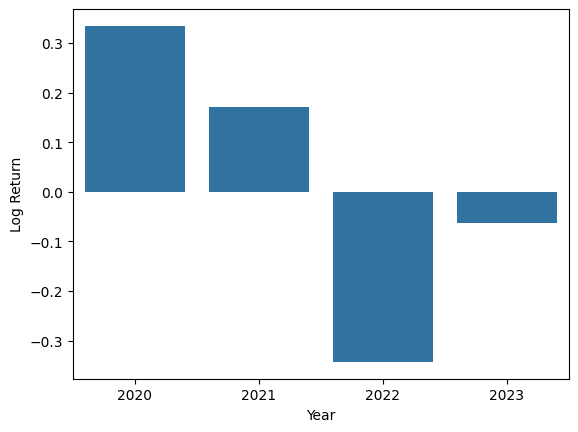

In [64]:
sns.barplot(return_by_year);

The presence of both strong positive and negative years above suggests that market behavior is regime-dependent rather than stable over time.

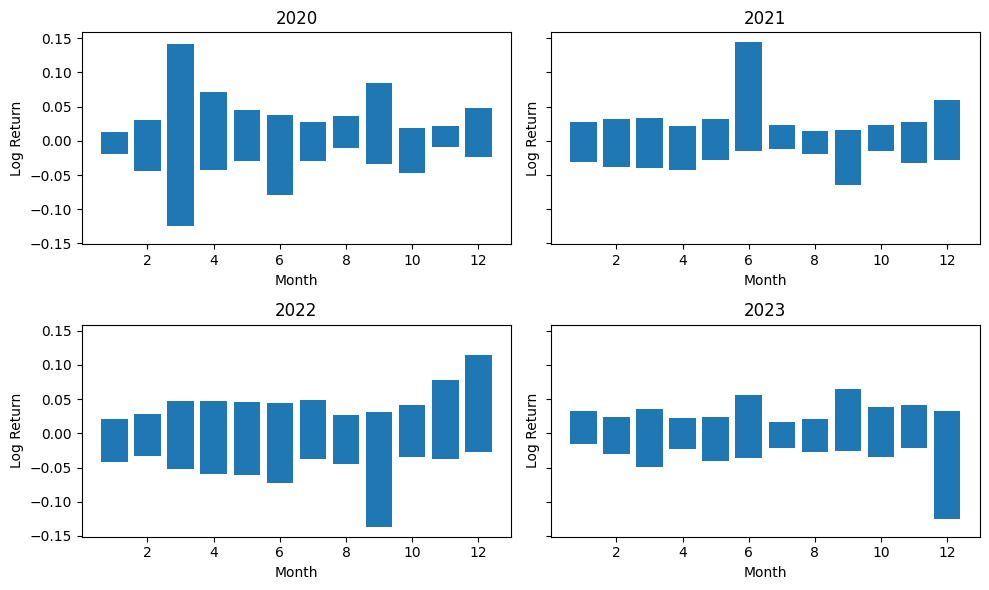

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
axes = axes.flatten()

for ax, (year,data) in zip(axes, nike.groupby('Year')):
    ax.bar(data['Month'], data['Log Return'])
    ax.set_title(str(year))
    ax.set_xlabel('Month')
    ax.set_ylabel('Log Return')

plt.tight_layout()
plt.show()

The magnitude and sign of monthly returns above appear to be driven more by year-specific market conditions than by the calendar month itself.

Average daily log returns are grouped by day of the week to examine whether return behavior differs systematically across trading days.

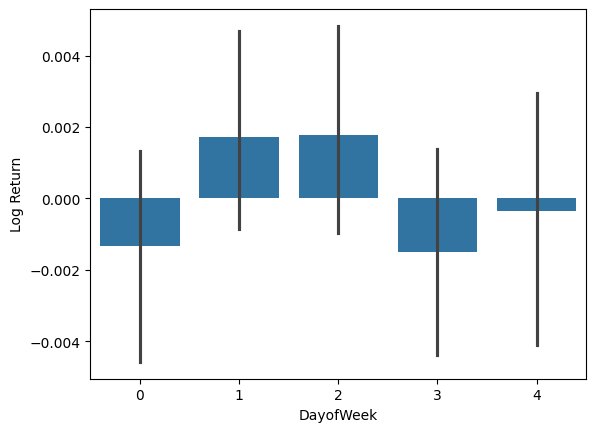

In [78]:
sns.barplot(data=nike,x='DayofWeek', y='Log Return');

Mean log returns across weekdays are close to zero, with only minor differences between days.

<h2>Stock Analysis using Models<h2>

We define a binary target to indicate whether the closing price increases on the following trading day. This serves as a simple experimental formulation rather than a claim of reliable short-term predictability.

In [41]:
nike['NextDayReturn'] = (nike['Log Return'].shift(-1) > 0).astype(int)
nike

,Close,High,Low,Open,Volume,Date,Open-to-Close Return(%),Log Return,NextDayReturn
2,95.368217,95.377551,94.267097,94.584372,5644100,2020-01-02,0.828726,NaN,0
3,95.106934,95.181588,93.604557,93.865839,4541800,2020-01-03,1.322201,-0.002743,0
4,95.022926,95.032253,94.127101,94.201748,4612400,2020-01-06,0.871724,-0.000884,0
5,94.976273,95.872098,94.071113,95.004266,6719900,2020-01-07,-0.029465,-0.000491,0
6,94.761658,95.312214,94.108447,94.537696,4942200,2020-01-08,0.236902,-0.002262,0
...,...,...,...,...,...,...,...,...,...
1003,104.985367,107.667335,104.412044,105.199148,46666200,2023-12-22,-0.203216,-0.125854,0
1004,104.965927,105.616990,104.441201,105.238017,12846700,2023-12-26,-0.258547,-0.000185,0
1005,104.101097,105.519817,103.829015,105.276886,10157900,2023-12-27,-1.116854,-0.008273,1
1006,105.743309,106.306912,103.790136,104.178828,9352900,2023-12-28,1.501726,0.015652,0


A correlation matrix is used as an exploratory tool to examine linear relationships between engineered features.

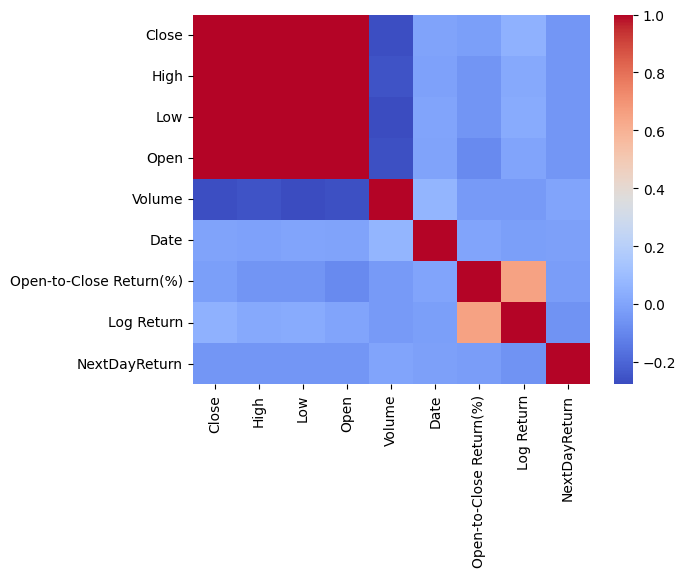

In [ ]:
corr = nike.corr()
sns.heatmap(corr, annot=False,cmap='coolwarm');

The correlation matrix above shows strong relationships among raw price variables and weak linear relationships between engineered features and the next-day return label. This suggests limited linear signal at daily frequency and motivates cautious interpretation of model performance.

Data Preperation / Cleaning

In [ ]:
nike

In [ ]:
nike.isnull().sum()

In [ ]:
nikeDF = nike.dropna(axis=0)

In [ ]:
nikeDF.head(10)

In [ ]:
nikeDF.isnull().sum() == 0

In [ ]:
winsorizedClosing = winsorize(nikeDF['Open-to-Close Return(%)'],(0.05,0.05)).data
nikeDF['Open-to-Close Return(%)'] = winsorizedClosing

In [ ]:
winsorizedRet = winsorize(nikeDF['Log Return'],(0.05,0.05)).data
nikeDF['Log Return'] = winsorizedRet

In [ ]:
winsorizedVol = winsorize(nikeDF['volatility'],(0.05,0.05)).data
nikeDF['volatility'] = winsorizedVol

In [ ]:
nikeDF

Logistic Regression

In [ ]:
nikeDum = pd.get_dummies(nikeDF, columns=['Month', 'Year', 'DayofWeek'], drop_first=True)

In [ ]:
nikeDum

In [ ]:
X = nikeDum.drop(['Date','NextDayReturn'],axis=1)
y = nikeDum['NextDayReturn']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

log_model = LogisticRegressionCV()

In [ ]:
log_model.fit(X_train_sc,y_train)

In [ ]:
log_model.C_

In [ ]:
coefs = pd.Series(index=X.columns,data=log_model.coef_[0]).sort_values()
sns.barplot(x=coefs.index,y=coefs.values)
plt.xticks(rotation=90);

In [ ]:
from sklearn.metrics import classification_report

yPreds = log_model.predict(X_test_sc)

In [ ]:
print(classification_report(y_test,yPreds))

RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
n_estimators = [64,100,128,175]
max_features = ['auto','log2','sqrt']
bootstrap = [True,False]
oob_score = [True,False]

In [ ]:
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'oob_score': oob_score
}

In [ ]:
grid = GridSearchCV(rfc,param_grid)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

In [ ]:
pred = grid.predict(X_test)

In [ ]:
print(classification_report(y_test,pred))